# 📘 2D Gaussian Fitting: Image Analysis and Peak Detection⏱️ **20-30 minutes** | 📊 **Level: ●●○ Intermediate** | 🏷️ **Core Tutorial**---

## 🎯 What You'll Learn- ✓ Fit 2D Gaussian functions to image data- ✓ Handle rotation and elliptical shapes- ✓ Manage memory for 2D datasets- ✓ Visualize 2D fitting results---

## Setup and ConfigurationConfigure environment for GPU memory handling:

In [1]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

In [2]:
from IPython.display import display

In [3]:
import os
import sys

os.environ["JAX_PREALLOCATE_GPU_MEMORY"] = "false"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import jax.numpy as jnp

from nlsq import CurveFit, estimate_memory_requirements

print("✅ Environment configured")


⚠️  GPU ACCELERATION AVAILABLE
═══════════════════════════════
NVIDIA GPU detected: NVIDIA GeForce RTX 4090 Laptop GPU
JAX is currently using: CPU-only

Enable 150-270x speedup with GPU acceleration:
  make install-jax-gpu

Or manually:
  pip uninstall -y jax jaxlib
  pip install "jax[cuda12-local]>=0.6.0"

See README.md GPU Installation section for details.

✅ Environment configured


## Define 2D Gaussian ModelModel: $f(x,y) = A \cdot e^{-0.5(X^2/\sigma_x^2 + Y^2/\sigma_y^2)} + C$Where X, Y are rotated coordinates.

In [4]:
def gaussian2d(coords, n0, x0, y0, sigma_x, sigma_y, theta, offset):
    """2D Gaussian with rotation.

    Args:
        coords: List of [x, y] coordinate arrays (can be 1D or 2D)
        n0: Amplitude
        x0, y0: Center coordinates
        sigma_x, sigma_y: Standard deviations
        theta: Rotation angle
        offset: Baseline offset

    Returns:
        Flattened 1D array of Gaussian values
    """
    # Get coordinates and ensure they're arrays
    x, y = coords
    x_flat = jnp.asarray(x).flatten()
    y_flat = jnp.asarray(y).flatten()

    # Translate to center
    x_centered = x_flat - x0
    y_centered = y_flat - y0

    # Rotate coordinates
    cos_theta = jnp.cos(theta)
    sin_theta = jnp.sin(theta)
    x_rot = cos_theta * x_centered - sin_theta * y_centered
    y_rot = sin_theta * x_centered + cos_theta * y_centered

    # Compute Gaussian
    density = n0 * jnp.exp(-0.5 * (x_rot**2 / sigma_x**2 + y_rot**2 / sigma_y**2))

    return density + offset


print("✅ 2D Gaussian model defined")

✅ 2D Gaussian model defined


## Generate Synthetic 2D DataCreate test image with Gaussian peak:

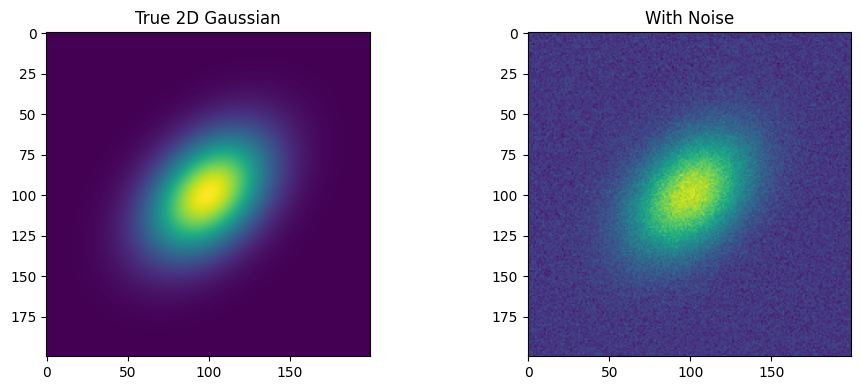

Data shape: (200, 200)


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Create meshgrid
length = 200
x = np.linspace(-5, 5, length)
y = np.linspace(-5, 5, length)
X, Y = np.meshgrid(x, y)

# True parameters
params_true = [100, 0, 0, 1.5, 1.0, np.pi/4, 10]

# Generate data (gaussian2d expects flattened coords and returns flattened array)
data_true_flat = gaussian2d([X.flatten(), Y.flatten()], *params_true)
data_true = data_true_flat.reshape(X.shape)
noise = np.random.normal(0, 5, data_true.shape)
data = data_true + noise

fig = plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.imshow(data_true, cmap="viridis")
plt.title("True 2D Gaussian")

plt.subplot(122)
plt.imshow(data, cmap="viridis")
plt.title("With Noise")

plt.tight_layout()

plt.show()

print(f"Data shape: {data.shape}")

## Fit the 2D GaussianFit with parameter bounds:

In [6]:
# Initial guess
p0 = [90, 0.5, 0.5, 1.2, 0.8, 0, 5]

# Bounds
bounds = ([0, -5, -5, 0.1, 0.1, -np.pi, 0],
          [200, 5, 5, 5, 5, np.pi, 50])

# Fit - flatten coordinates and data for curve_fit
jcf = CurveFit()
popt, pcov = jcf.curve_fit(
    gaussian2d,
    [X.flatten(), Y.flatten()],  # Flatten coordinates to match flattened data
    data.flatten(),  # Flatten the 2D data to 1D
    p0=p0,
    bounds=bounds
)

print("Fitted Parameters:")
print(f"  Amplitude: {popt[0]:.1f} (true: {params_true[0]})")
print(f"  Center X:  {popt[1]:.2f} (true: {params_true[1]})")
print(f"  Center Y:  {popt[2]:.2f} (true: {params_true[2]})")
print(f"  Sigma X:   {popt[3]:.2f} (true: {params_true[3]})")
print(f"  Sigma Y:   {popt[4]:.2f} (true: {params_true[4]})")
print(f"  Rotation:  {popt[5]:.2f} rad (true: {params_true[5]:.2f})")
print(f"  Offset:    {popt[6]:.1f} (true: {params_true[6]})")

INFO:nlsq.curve_fit:Starting curve fit | {'n_params': 7, 'n_data_points': 40000, 'method': 'trf', 'solver': 'auto', 'batch_size': None, 'has_bounds': True, 'dynamic_sizing': False}


INFO:nlsq.least_squares:Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-08}


[WARNING] Sparsity detection failed: could not broadcast input array from shape (40000,) into shape (2,). Using dense solver.


PERFORMANCE:nlsq.least_squares:Timer: optimization took 1.344607s


INFO:nlsq.least_squares:Convergence: reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=4.991269e+05 | time=1.345s | final_gradient_norm=0.41351791693381973


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit took 1.741610s


INFO:nlsq.curve_fit:Curve fit completed | {'total_time': 1.741609767981572, 'final_cost': 998253.8007575633, 'covariance_warning': False}


Fitted Parameters:
  Amplitude: 100.0 (true: 100)
  Center X:  -0.00 (true: 0)
  Center Y:  0.00 (true: 0)
  Sigma X:   1.50 (true: 1.5)
  Sigma Y:   1.00 (true: 1.0)
  Rotation:  0.79 rad (true: 0.79)
  Offset:    10.0 (true: 10)


## Visualize ResultsCompare data, fit, and residuals:

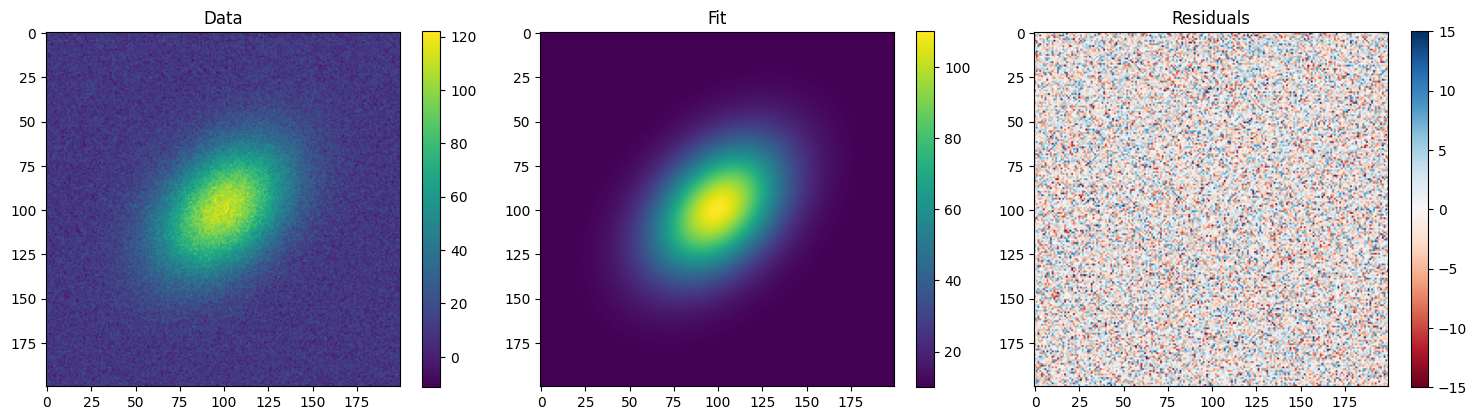


RMSE: 5.00


In [7]:
# Generate fitted surface
data_fit_flat = gaussian2d([X.flatten(), Y.flatten()], *popt)
data_fit = data_fit_flat.reshape(data.shape)  # Reshape back to 2D for visualization
residuals = data - data_fit

fig = plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.imshow(data, cmap="viridis")
plt.title("Data")
plt.colorbar()

plt.subplot(132)
plt.imshow(data_fit, cmap="viridis")
plt.title("Fit")
plt.colorbar()

plt.subplot(133)
plt.imshow(residuals, cmap="RdBu", vmin=-15, vmax=15)
plt.title("Residuals")
plt.colorbar()

plt.tight_layout()

plt.show()

rmse = np.sqrt(np.mean(residuals**2))
print(f"\nRMSE: {rmse:.2f}")

## Key Takeaways1. **2D Gaussian fitting** handles image analysis and peak detection2. **Rotation parameter** enables elliptical peak fitting3. **Memory management** is crucial for large images4. **Bounds** ensure physical constraints are met---

## 🔗 Next Steps**Continue learning:**- [Large Dataset Demo](large_dataset_demo.ipynb)- [Performance Optimization](performance_optimization_demo.ipynb)- [Advanced Topics](../03_advanced/)---